# CMS Synthetic Claims Public Use Files Exploration

This notebook includes code that aggregates and explores the claims files included in the 2008-2010 synthetic public use files. More information about the dataset can be found here: https://www.cms.gov/data-research/statistics-trends-and-reports/medicare-claims-synthetic-public-use-files/cms-2008-2010-data-entrepreneurs-synthetic-public-use-file-de-synpuf

The exploration includes some silly associations between trends data and events during that time period including holidays and news-worthy happenings. This is not to suggest an actual correlation, but merely as an oportunity for exploration.

In [16]:
import os
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import holidays


In [2]:
data_root_path = "sample1/raw"

file_name_map = {
    'DE1_0_2009_Beneficiary_Summary_File_Sample_1.csv': '2009_Beneficiary_Summary', 
 'DE1_0_2008_to_2010_Inpatient_Claims_Sample_1.csv': 'Inpatient_Claims', 
 'DE1_0_2008_Beneficiary_Summary_File_Sample_1.csv': '2008_Beneficiary_Summary', 
 'DE1_0_2010_Beneficiary_Summary_File_Sample_1.csv': '2010_Beneficiary_Summary', 
 'DE1_0_2008_to_2010_Outpatient_Claims_Sample_1.csv': 'Outpatient_Claims',
}


In [3]:
spark = SparkSession.builder.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/06 13:21:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
dataframes = {}
for file_name, variable_name in file_name_map.items():
    file_path = os.path.join(data_root_path, file_name)
    dataframes[variable_name] = spark.read.csv(file_path, header=True, inferSchema=True)


In [51]:
#explore the dataframes
#for variable_name, df in dataframes.items():
#    print(f"Dataframe: {variable_name}")
#    df.show(5)
#    df.printSchema()
#    print("\n")


In [26]:
#Make Single Beneficiary Dataframe
beneficiary_df = dataframes['2009_Beneficiary_Summary'].union(dataframes['2008_Beneficiary_Summary']).union(dataframes['2010_Beneficiary_Summary'])

#merge beneficiary and claims dataframes
inpatient_claims_df = dataframes['Inpatient_Claims'].join(beneficiary_df, on='DESYNPUF_ID', how='inner')
outpatient_claims_df = dataframes['Outpatient_Claims'].join(beneficiary_df, on='DESYNPUF_ID', how='inner')


In [49]:
# clean up some columns
inpatient_claims_df = inpatient_claims_df.withColumn("CLM_FROM_DT", F.to_date(F.col("CLM_FROM_DT"), "yyyyMMdd"))

outpatient_claims_df = outpatient_claims_df.withColumn("CLM_FROM_DT", F.to_date(F.col("CLM_FROM_DT"), "yyyyMMdd"))

## Comparing Claims to Holidays

In [44]:
def aggregate_claim_date(df):
    claims_df = df.select(F.col("CLM_FROM_DT"))\
    .groupBy("CLM_FROM_DT")\
    .agg(F.count("CLM_FROM_DT").alias("Total_Claims")) \
        .orderBy("CLM_FROM_DT")
    
    day_pd = claims_df.toPandas()
    return day_pd.loc[day_pd['Total_Claims'] > 0]

def get_holiday_labels(df):
    us_holidays = holidays.US(years=[2008, 2009, 2010])
    holiday_dates = [date for date in us_holidays.keys() if str(date) in df["CLM_FROM_DT"].astype(str).values]
    return holiday_dates, [us_holidays[date] for date in holiday_dates]

### Inpatient Claims to Holidays

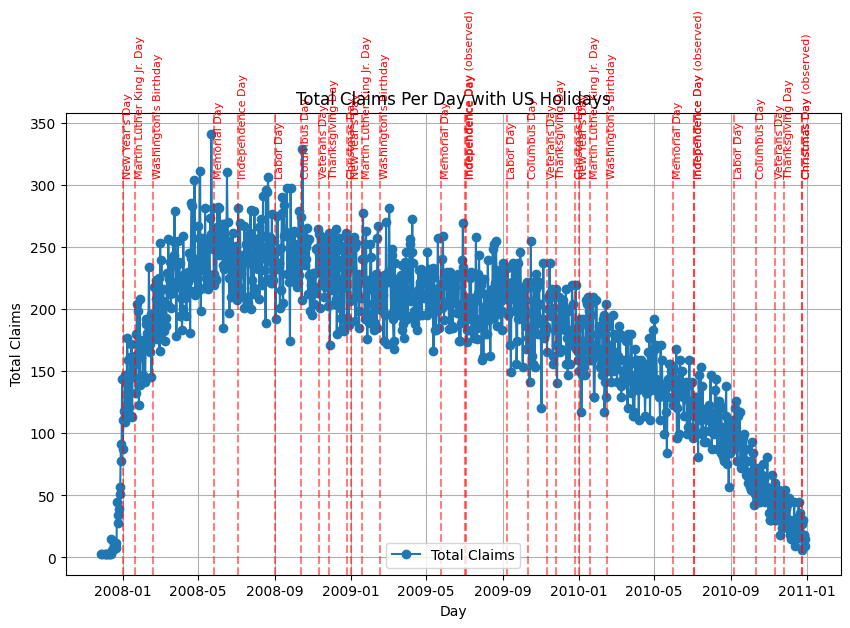

In [ ]:
inpatient_day_pd = aggregate_claim_date(inpatient_claims_df)

inpatient_holiday_dates, inpatient_holiday_labels = get_holiday_labels(inpatient_day_pd)


plt.figure(figsize=(10, 6))
plt.plot(inpatient_day_pd["CLM_FROM_DT"], inpatient_day_pd["Total_Claims"], marker="o", linestyle="-", label="Total Claims")

# Annotate holidays
for date, label in zip(inpatient_holiday_dates, inpatient_holiday_labels):
    plt.axvline(x=date, color="red", linestyle="--", alpha=0.5)  # Add vertical lines for holidays
    plt.text(date, max(inpatient_day_pd["Total_Claims"]) * 0.9, label, rotation=90, fontsize=8, color="red")  # Add holiday labels

# Add labels and title
plt.title("Total Claims Per Day with US Holidays")
plt.xlabel("Day")
plt.ylabel("Total Claims")
plt.legend()
plt.grid(True)
plt.show()

You can see from this plot that inpatient claims peak on Memorial and Indigenous People's day.

### Outpatient Claims by Holidays

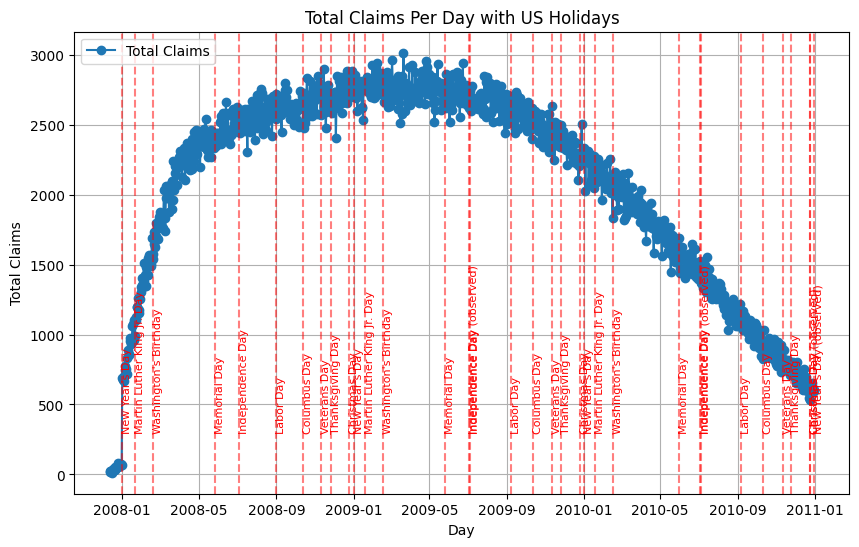

In [50]:
outpatient_day_pd = aggregate_claim_date(outpatient_claims_df)

outpatient_holiday_dates, outpatient_holiday_labels = get_holiday_labels(outpatient_day_pd)


plt.figure(figsize=(10, 6))
plt.plot(outpatient_day_pd["CLM_FROM_DT"], outpatient_day_pd["Total_Claims"], marker="o", linestyle="-", label="Total Claims")

# Annotate holidays
for date, label in zip(outpatient_holiday_dates, outpatient_holiday_labels):
    plt.axvline(x=date, color="red", linestyle="--", alpha=0.5)  # Add vertical lines for holidays
    plt.text(date, max(inpatient_day_pd["Total_Claims"]) * 0.9, label, rotation=90, fontsize=8, color="red")  # Add holiday labels

# Add labels and title
plt.title("Total Claims Per Day with US Holidays")
plt.xlabel("Day")
plt.ylabel("Total Claims")
plt.legend()
plt.grid(True)
plt.show()